# Homework 3
In this homework we are going to implement the TRIÈST algorithm for estimating the global and local number of triangles of a graph in a single pass. In this specific case we are going to implement only the BASE and the IMPROVED versions of the algorithm.

## TRIÈST
TRIÈST is an algorithm for estimating the number of triangles in a graph. It is an edge sampling algorithm, which means that it works by randomly selecting a subset of the edges of the graph and then use this sample to compute the estimate. The algorithm is designed to work in a single pass, which means that it only reads the input once and does not store it in memory. This is a very important feature, since it allows the algorithm to be applied to graphs that are too large to fit in memory while still being fast.

To test the algorithm we use the Google Web Graph ([Link](https://snap.stanford.edu/data/web-Google.html)). This graph is a web graph where the nodes represent web pages and the edges represent hyperlinks between them. The graph is directed and the edges are ordered by the date in which they were created.

As well, to test the algorithm we use the Notre Dame Web Graph ([Link](https://snap.stanford.edu/data/web-NotreDame.html)). This graph is a web graph where the nodes represent web pages and the edges represent hyperlinks between them. The graph is directed and the edges are ordered by the date in which they were created.

In [7]:
import gzip

edges: list[tuple[int, int]] = []

with gzip.open('datasets/web-NotreDame.txt.gz', 'rb') as f:
    for line in f:
        words:list[str] = line.decode('utf-8').split()
        if words[0] == '#':
            continue
        src_node: int = int(words[0])
        dst_node: int = int(words[1])
        if src_node == dst_node:
            continue
        elif src_node > dst_node:
            src_node, dst_node = dst_node, src_node
        edges.append((src_node, dst_node))

# real_number_of_triangles: int = 13391903 # Google
real_number_of_triangles: int = 8910005 # NotreDame


Before starting implementing our first algorithm, the TRIÈST-BASE, we need to create a class which will be helpful to generate the subgraphs for the TRIÈST. The idea of TRIÈST is to create a subgraph, and create the estimator based on the subgraph. The subgraph is created by sampling the edges of the graph.

In [8]:
class SubGraph:
    """
    A subgraph helpful for the TRIÈST Algorithm.
    """

    def __init__(self):
        self.edges: set[tuple[int, int]] = set()
        self.vertices: dict[int, list[int]] = dict() # {edge_u} -> {edge_v}

    def add_edge(self, edge: tuple[int, int]) -> None:
        """
        Add an edge to the subgraph.
        """
        self.edges.add(edge)
        self.vertices[edge[0]] = self.vertices.get(edge[0], []) + [edge[1]]
        self.vertices[edge[1]] = self.vertices.get(edge[1], []) + [edge[0]]

    def remove_edge(self, edge: tuple[int, int]) -> None:
        """
        Remove an edge from the subgraph.
        """
        self.edges.remove(edge)
        self.vertices[edge[0]].remove(edge[1])
        self.vertices[edge[1]].remove(edge[0])
        if self.vertices[edge[0]] == 0:
            del self.vertices[edge[0]]
        if self.vertices[edge[1]] == 0:
            del self.vertices[edge[1]]

    def has_vertix(self, vertix: int) -> bool:
        return vertix in self.vertices
    
    def has_edge(self, edge: tuple[int, int]) -> bool:
        return edge in self.edges
    
    def get_vertices(self) -> list[int]:
        return list(self.vertices.keys())
    
    def get_edges(self) -> list[tuple[int, int]]:
        return list(self.edges)
    
    def get_neighbors(self, vertix: int) -> list[int]:
        return list(self.vertices.get(vertix))

## TRIÈST-BASE
Now that we have implemented the class for the subgraph, we can start implementing the TRIÈST-BASE algorithm. The core idea of the algorithm is to create a subgraph by sampling randomly the edges of the graph and then use the subgraph to compute the estimator. In the BASE algorithm, there are only additions, not deletions.

- TRIÈST-BASE uses a *random sampling scheme* known as reservoir sampling (M).
- At any time t <= M, deterministically insert the edge currently on the stream into S.
- At any t > M, flip a coin with tail-bias M / t
- If the outcome is head, do nothing
- If the outcome is tail
1. Choose an edge in S uniformly at random and replace it with the edge currently on the stream
2. Decrease global counter and local counter of triangles byt the no. of triangles involving the removed edge
3. Increase global counter and local counter of triangles by the no. of triangles involving the inserted edge

In [9]:
import random
from itertools import chain

class TriestBase:
    
    def __init__(self, reservoir_size: int):
        self.reservoir_size: int = reservoir_size
        self.subgraph: SubGraph = SubGraph()
        self.global_counter: int = 0
        self.local_counters: dict[int, int] = dict()

    def update_counters(self, op: str, edge: tuple[int, int]) -> None:
        """
        Update the global and local counters.
        """
        if not self.subgraph.has_vertix(edge[0]) or not self.subgraph.has_vertix(edge[1]):
            return
        
        neighbors_u: list[int] = self.subgraph.get_neighbors(edge[0])
        neighbors_v: list[int] = self.subgraph.get_neighbors(edge[1])

        shared_neighbors: list[int] = list(set(neighbors_u).intersection(neighbors_v))

        value: int = 1 if op == '+' else -1

        for vertix in shared_neighbors:
            self.global_counter += value
            self.local_counters[vertix] = self.local_counters.get(vertix, 0) + value
            self.local_counters[edge[0]] = self.local_counters.get(edge[0], 0) + value
            self.local_counters[edge[1]] = self.local_counters.get(edge[1], 0) + value

        if op == '-':
            for c in chain(shared_neighbors, edge):
                if c in self.local_counters and self.local_counters[c] <= 0:
                    del self.local_counters[c]

    def sample_edge(self, t: int) -> None:
        """
        Sample an edge from the stream.
        """
        # If the subgraph is empty, add the edge
        if t <= self.reservoir_size:
            return True
        
        # Changing an edge with probability M/t
        if random.random() < self.reservoir_size / t:
            edge_list: list = self.subgraph.get_edges()
            edge: tuple[int, int] = random.choice(edge_list)
            self.subgraph.remove_edge(edge)
            self.update_counters('-', edge)
            return True
        return False
    
    def compute_eta(self, t: int) -> float:
        return max(1, t*(t-1)*(t-2) / (self.reservoir_size*(self.reservoir_size-1)*(self.reservoir_size-2)))
    
    def algorithm(self, edges: list[tuple[int, int]]) -> int:
        t: int = 0

        for edge in edges:
            if self.subgraph.has_edge(edge):
                continue
        
            t += 1
            if self.sample_edge(t):
                self.subgraph.add_edge(edge)
                self.update_counters('+', edge)

        eta: float = self.compute_eta(t)
        global_triangles: int = int(self.global_counter * eta)

        print(f'Global triangles estimate: {global_triangles}')
        local_triangles = {node: int(eta * counter) for node, counter in self.local_counters.items()}
        print(f'Local triangles estimate: {local_triangles}')

        return global_triangles

In [10]:
import matplotlib.pyplot as plt
from datetime import datetime

m_values: list[int] = [5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
global_triangle_estimates: list[int] = []
timings: list[datetime] = []

for m in m_values:
    start_time: datetime = datetime.now()
    triest = TriestBase(m)
    global_triangle_estimates.append(triest.algorithm(edges))
    timings.append(datetime.now() - start_time)

plt.title('Triest-Base')
plt.plot(m_values, global_triangle_estimates)
plt.xlabel('M'); plt.ylabel('Triangles')
plt.axhline(real_number_of_triangles, linestyle='--', color='r', label='Real number of triangles')
plt.legend()
plt.show()

plt.title('Triest-Base')
plt.plot(m_values, [t.total_seconds() for t in timings])
plt.xlabel('M'); plt.ylabel('Time (seconds)')
plt.show()


Global triangles estimate: 75572301
Local triangles estimate: {229835: 25190767, 229856: 25190767, 229864: 25190767, 234002: 25190767, 234050: 25190767, 234086: 25190767, 234646: 25190767, 234648: 25190767, 234654: 25190767}
Global triangles estimate: 74351255
Local triangles estimate: {121923: 7435125, 122657: 7435125, 175011: 7435125, 229062: 7435125, 229117: 7435125, 229193: 7435125, 230186: 7435125, 230237: 7435125, 230293: 7435125, 231347: 7435125, 231335: 7435125, 231381: 7435125, 231332: 7435125, 231416: 7435125, 231430: 7435125, 231377: 7435125, 231412: 7435125, 231436: 7435125, 234054: 7435125, 234046: 7435125, 234139: 7435125, 258431: 7435125, 258443: 7435125, 258477: 14870251, 258392: 7435125, 258372: 7435125, 260314: 7435125, 260303: 7435125, 260335: 7435125}
Global triangles estimate: 90627480
Local triangles estimate: {122425: 3125085, 122447: 3125085, 175089: 3125085, 229070: 3125085, 229091: 3125085, 229106: 3125085, 229087: 3125085, 229088: 3125085, 229172: 3125085, 23

KeyboardInterrupt: 

## TRIÈST-IMPR
The weaknesses of the TRIÈST-BASE are the following:
1. BASE uses the exact value of the global counter at time t to estimate the number of triangles at time t. Over time the global counter may decrease, and so would the estimation... while the estimation never decreases over time.
2. BASE only counts a triangle if all three edges are in S... but if 2 edges are in S, and the third is one on the stream right now, we may infer that the triangle exists, so we should count it.

TRIÈST-IMPR solves these weaknesses, resulting in estimates with lower variance.

The possible solutions TRIÈST-IMPR introduces are the following:
1. Never decrease the estimate, i.e, use Gs only to indentify new triangles.
2. First increment the counters, then decide whether to insert the edge into S.

In [ ]:
class TriestImpr:
    def __init__(self, reservoir_size: int):
        self.reservoir_size: int = reservoir_size
        self.subgraph: SubGraph = SubGraph()
        self.global_counter: float = 0
        self.local_counters: dict[int, float] = dict()

    def update_counters(self, t: int, edge: tuple[int, int]) -> None:
        """
        Update the global and local counters.
        """
        if not self.subgraph.has_vertix(edge[0]) or not self.subgraph.has_vertix(edge[1]):
            return
        
        neighbors_u: list[int] = self.subgraph.get_neighbors(edge[0])
        neighbors_v: list[int] = self.subgraph.get_neighbors(edge[1])

        shared_neighbors: list[int] = list(set(neighbors_u).intersection(neighbors_v))

        value: float = self.compute_eta(t)

        for vertix in shared_neighbors:
            self.global_counter += value
            self.local_counters[vertix] = self.local_counters.get(vertix, 0) + value
            self.local_counters[edge[0]] = self.local_counters.get(edge[0], 0) + value
            self.local_counters[edge[1]] = self.local_counters.get(edge[1], 0) + value

    def sample_edge(self, t: int) -> None:
        """
        Sample an edge from the stream.
        """
        # If the subgraph is empty, add the edge
        if t <= self.reservoir_size:
            return True
        
        # Changing an edge with probability M/t
        if random.random() < self.reservoir_size / t:
            edge_list: list = self.subgraph.get_edges()
            edge: tuple[int, int] = random.choice(edge_list)
            self.subgraph.remove_edge(edge)
            # Do not update counters here
            return True
        return False
    
    def compute_eta(self, t: int) -> float:
        return max(1, (t-1)*(t-2) / (self.reservoir_size*(self.reservoir_size-1)))
    
    def algorithm(self, edges: list[tuple[int, int]]) -> int:
        t: int = 0

        for edge in edges:
            if self.subgraph.has_edge(edge):
                continue
        
            t += 1
            self.update_counters(t, edge)
            if self.sample_edge(t):
                self.subgraph.add_edge(edge)

        global_triangles: int = int(self.global_counter)

        print(f'Global triangles estimate: {global_triangles}')
        local_triangles = {node: int(counter) for node, counter in self.local_counters.items()}
        print(f'Local triangles estimate: {local_triangles}')

        return global_triangles

Global triangles estimate: 0
Local triangles estimate: {}
Global triangles estimate: 0
Local triangles estimate: {}
Global triangles estimate: 131972841
Local triangles estimate: {296657: 131972841, 460799: 131972841, 727594: 131972841}
Global triangles estimate: 0
Local triangles estimate: {}
Global triangles estimate: 49138346
Local triangles estimate: {730958: 16379448, 476123: 16379448, 852170: 16379448, 555176: 16379448, 638821: 16379448, 801922: 16379448, 660391: 16379448, 839947: 16379448, 864324: 16379448}
Global triangles estimate: 8359667
Local triangles estimate: {548837: 8359667, 625664: 8359667, 880260: 8359667}
Global triangles estimate: 53054222
Local triangles estimate: {277916: 4823111, 230908: 4823111, 455817: 4823111, 23526: 4823111, 763139: 4823111, 841054: 4823111, 120615: 4823111, 225658: 4823111, 241380: 4823111, 668657: 4823111, 140844: 4823111, 712590: 4823111, 422954: 4823111, 5766: 4823111, 339554: 4823111, 384217: 4823111, 159784: 4823111, 751629: 4823111, 1

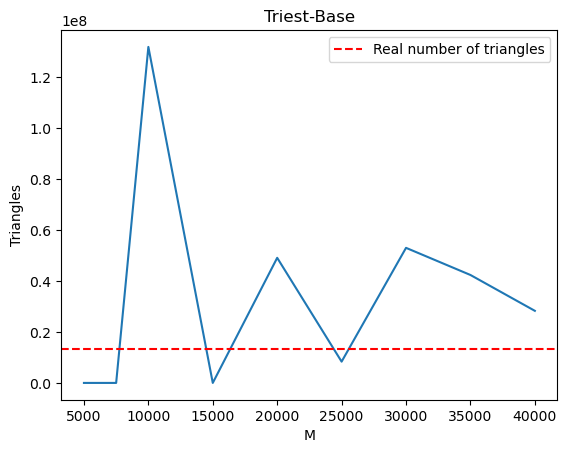

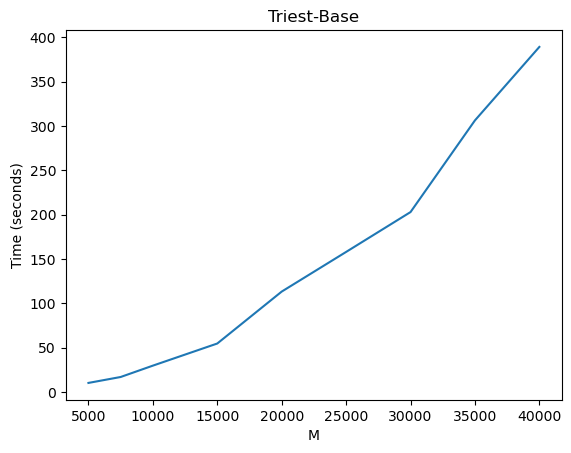

In [ ]:
m_values: list[int] = [5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
global_triangle_estimates: list[int] = []
timings: list[datetime] = []

for m in m_values:
    start_time: datetime = datetime.now()
    triest = TriestBase(m)
    global_triangle_estimates.append(triest.algorithm(edges))
    timings.append(datetime.now() - start_time)

plt.title('Triest-Impr')
plt.plot(m_values, global_triangle_estimates)
plt.xlabel('M'); plt.ylabel('Triangles')
plt.axhline(real_number_of_triangles, linestyle='--', color='r', label='Real number of triangles')
plt.legend()
plt.show()

plt.title('Triest-Impr')
plt.plot(m_values, [t.total_seconds() for t in timings])
plt.xlabel('M'); plt.ylabel('Time (seconds)')
plt.show()


## Extra questions

1. What were the challenges you faced when implementing the algorithm?

- *The main challenge was to understand the algorithm and how it works. It is my first time implementing and playing with Graphs, so it was a bit challenging to understand the logic behind the algorithm. After reading and watching several conferences from the creators, I was able to understand enough to do the implementation.*


2. Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.

- *No, I do not think the algorithm can be easily parallelized. First of all, we are keeping a subgraph in memory. In case we do a change or we have to add/delete a vertex we can lose track of the counting in case we are having the subgraph divided into multiple clusters of computers due to the latency. Network latency can be challenging and, at the end, being a problem itself for such algorithms. Perhaps using an implementation in C++ or other more efficient programming languages than Python is more than enough.*

3. Does the algorithm work for unbounded graph streams? Explain.

- *Yes, the algorithm works for unbounded graph streams. The algorithm is designed to work in a single pass, which means that it only reads the input once and does not store it in memory. This is a very important feature, since it allows the algorithm to be applied to graphs that are too large to fit in memory while still being fast. As well, it can be aplied for stream graphs.*

4. Does the algorithm support edge deletions? If not, what modification would it need? Explain.

- *In TRIÈST-FD (Fully Dynamic) there is support for edge deletions, but not in TRIÈST-BASE & TRIÈST-IMPR. Based on Matteo Riondato, one of the creators of the algorithm, handling deletions is hard. The approach in TRIÈST-FD is inspired by random pairing.*


### Interesting links
https://www.twosigma.com/articles/triest-counting-local-and-global-triangles-in-fully-dynamic-streams-with-fixed-memory-size/
https://www.kdd.org/kdd2016/papers/files/rfp0465-de-stefaniA.pdf
